## K-Nearest Neighbour Model

### Imports and Utils

In [1]:
"""
Importing the necessary libraries
"""
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

### Dataset Loading and Preprocessing

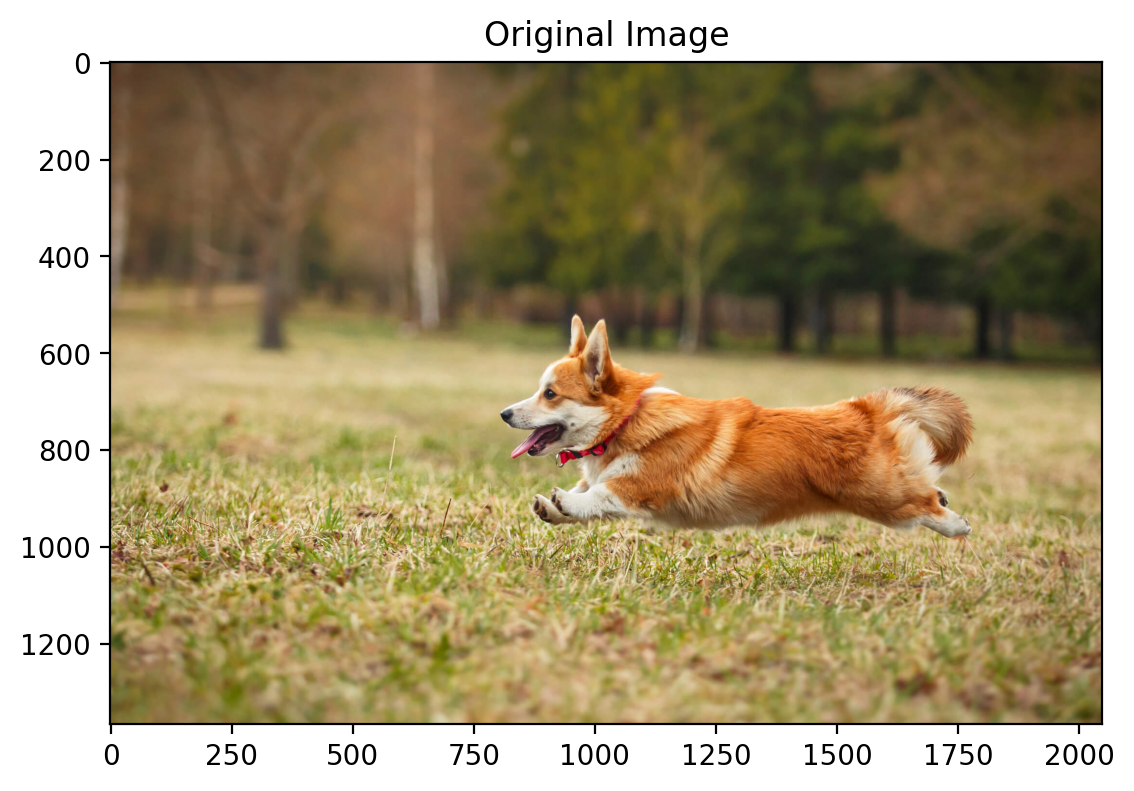

In [12]:
# Load the image
local_dir = "Images/"
path = os.path.join(local_dir, "dog.jpg")
image = torchvision.io.read_image(path)
image = image.float() / 255.0

# Display the image
plt.imshow(rearrange(image, 'c h w -> h w c').numpy())
plt.title("Original Image")
plt.show()

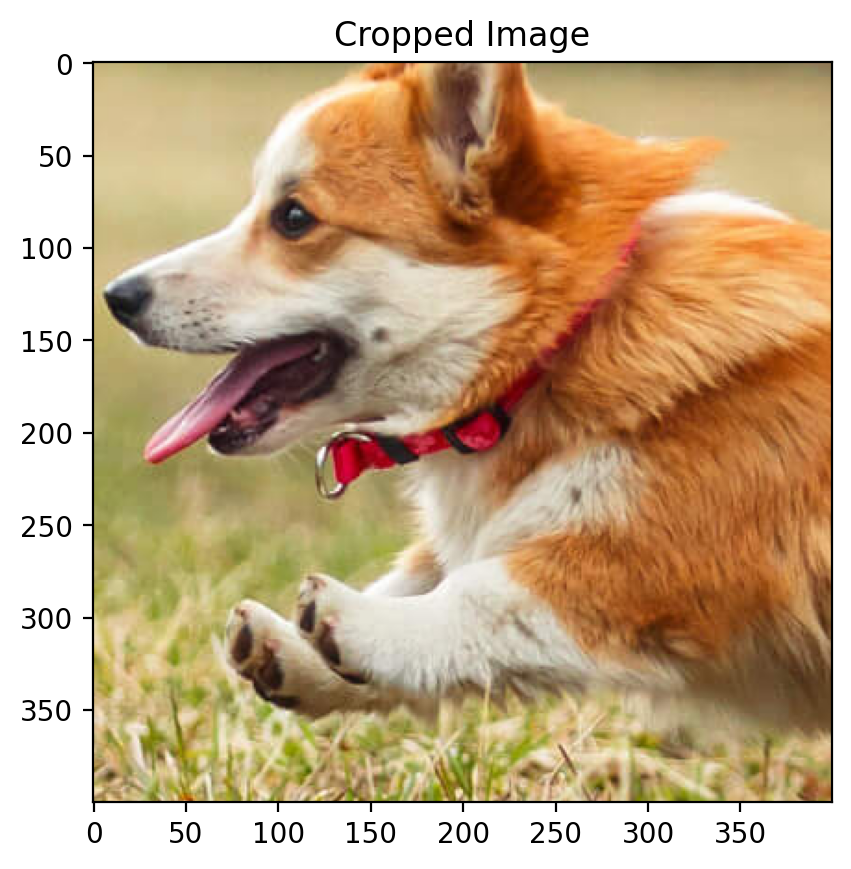

In [13]:
# Crop the image
image = torchvision.transforms.functional.crop(image.cpu(), 600, 800, 400, 400).to(device)

# Display the image
plt.imshow(rearrange(image, 'c h w -> h w c').numpy())
plt.title("Cropped Image")
plt.show()

### Model Creation and Training

In [42]:
class KMeans:
    """
    A KMeans clustering algorithm.
    """
    def __init__(self, n_clusters: int = 3):
        """
        Constructor for KMeans.

        n_clusters: int: The number of clusters.
        """
        self.n_clusters = n_clusters
        self.centroids = []

    def fit(self, X : torch.Tensor, max_iter : int = 100, tol : float = 1e-4):
        """
        X: torch.Tensor: The data to cluster.
        max_iter: int: The maximum number of iterations.
        tol: float: The tolerance for convergence.
        """

        X = X.to(device)
        self.findCenters(X)
        
        for _ in range(max_iter):
            distances = torch.cdist(X, torch.stack(self.centroids))
            labels = torch.argmin(distances, dim=1)

            centroids = []
            for i in range(self.n_clusters):
                if (labels == i).any():
                    centroids.append(X[labels == i].mean(dim=0))
                else:
                    centroids.append(X[np.random.randint(0, X.shape[0])])

            if torch.allclose(torch.stack(centroids), torch.stack(self.centroids), atol=tol):
                break
            
            self.centroids = centroids

    def predict(self, X):
        """
        X: torch.Tensor: The data to cluster.

        Returns: torch.Tensor: The cluster labels.
        """

        X = X.to(device)
        distances = torch.cdist(X, torch.stack(self.centroids))
        return torch.argmin(distances, dim=1)

    def findCenters(self, X):
        """
        X: torch.Tensor: The data to cluster.
        """

        self.centroids = [X[np.random.randint(0, X.shape[0])]]
        
        for _ in range(1, self.n_clusters):
            distances = torch.sum(torch.stack([torch.norm(X - c, dim=1) for c in self.centroids]), dim=0)
            self.centroids.append(X[torch.argmax(distances)])

In [55]:
# Defining the model
model = KMeans(n_clusters=5)

In [56]:
# Training the model
model.fit(image.reshape(-1, 3).float())

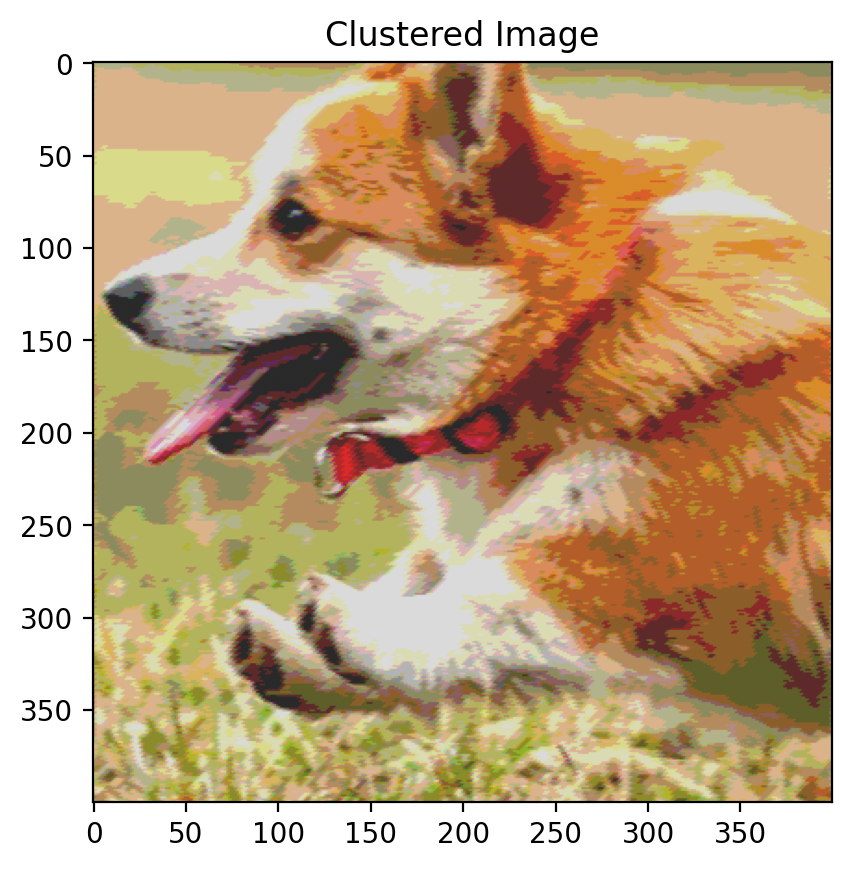

In [57]:
# Predicting the labels and segmenting the image
labels = model.predict(image.reshape(-1, 3).float())
segmented_image = torch.stack([model.centroids[i] for i in labels]).view(image.shape)

# Display the image
plt.imshow(rearrange(segmented_image, 'c h w -> h w c').cpu().numpy())
plt.title("Clustered Image")
plt.show()